# Designate Bike Routes for Commuting Professionals

Connect your ArcGIS online organization.

In [1]:
from arcgis import *

In [2]:
gis = GIS("https://deldev.maps.arcgis.com", "demos_deldev", "DelDevs12")

Accessing the content property of your gis object you can use the `search()` method. 
Search for **SeattleBikeRoutes** content made by other users by turning the **outside_org** to True.

<Item title:"SeattleBikeRoutes" type:Feature Layer Collection owner:VickiCove>
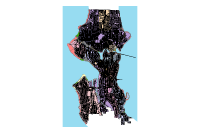

In [3]:
SeattleBikeRoutes = gis.content.search('title: "SeattleBikeRoutes"', 'Feature layer', outside_org=True)[0]
SeattleBikeRoutes

Import the **display** module to display the items.

In [4]:
from IPython.display import display

In [5]:
for lyr in SeattleBikeRoutes.layers:
    display(lyr.properties.name)

'Streets'

'Neighborhoods'

'Zoning'

In [6]:
bike_route_zoning = SeattleBikeRoutes.layers[2]

MapView(layout=Layout(height='400px', width='100%'))


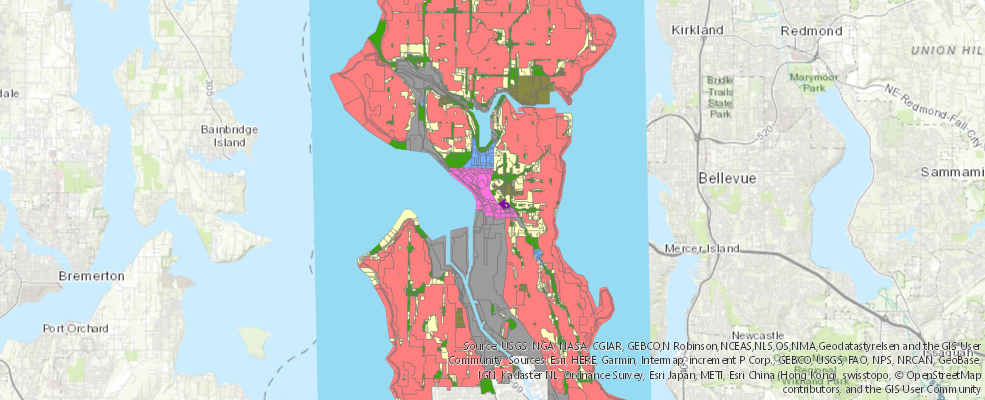

In [7]:
bike_zoning_map = gis.map('Seattle')
bike_zoning_map

In [8]:
bike_zoning_map.add_layer(bike_route_zoning)

Use a Filter on the Zoning layer to select the downtown office core. The downtown office core is a good starting point for creating commuter bike lanes because it is expected to have a large number of commuters each day.

In [10]:
bike_route_zoning.filter = "(ZONELUT_DE = 'Downtown Office Core 1') OR (ZONELUT_DE = 'Downtown Office Core 2')"

Esri's Tapestry Segmentation is a resource for businesses that classifies every Zip code in the United States into one of 67 segments based on demographic and socioeconomic factors.  

Search the Esri Tapestry Segmentation feature layer.

In [11]:
Tapestry_segmentation = gis.content.search('"2018 USA Tapestry segmentation"','Map Image Layer', outside_org=True)

<Item title:"2018 USA Tapestry Segmentation" type:Map Image Layer owner:esri>
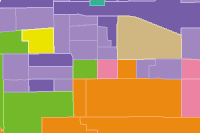

<Item title:"2018 USA Tapestry Segmentation" type:Map Image Layer owner:Virginia_Johnston>
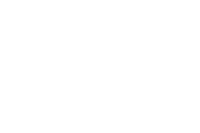

<Item title:"2018 USA Tapestry Segmentation" type:Map Image Layer owner:esri_devlabs>

In [12]:
for item in Tapestry_segmentation:
    display(item)

In [13]:
bike_route_neighbourhood = SeattleBikeRoutes.layers[1]

Apply a Filter to the Neighborhoods so that only Capitol Hill is showing.

In [14]:
bike_route_neighbourhood.filter = "L_HOOD = 'CAPITOL HILL'"

In [15]:
tapestry = Tapestry_segmentation[1]

In [16]:
bike_route_streets = SeattleBikeRoutes.layers[0]

In [17]:
bike_route_streets

<FeatureLayer url:"https://services6.arcgis.com/sdbe23RSJ4l0hdpd/arcgis/rest/services/SeattleBikeRoutes/FeatureServer/0">

MapView(layout=Layout(height='400px', width='100%'))


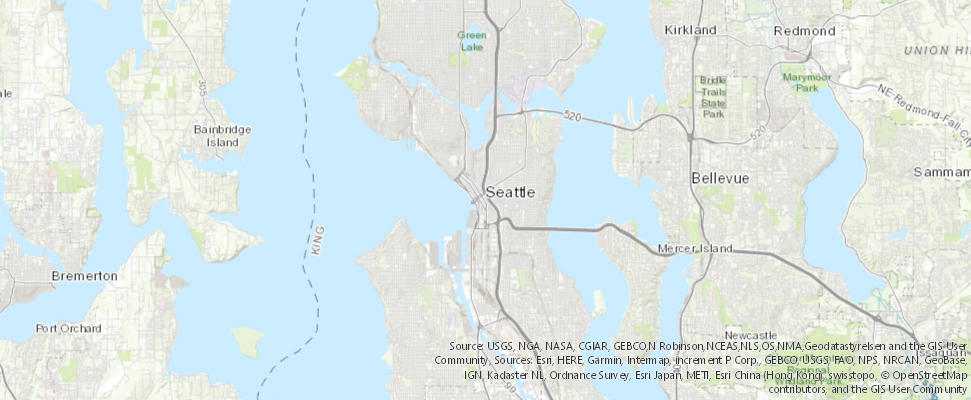

In [18]:
bike_street_map = gis.map('Seattle')
bike_street_map

In [19]:
bike_street_map.add_layer(bike_route_streets)

Identify potential bike routes

The Streets layer includes main streets, trails, and other street types. Look at the trails first to determine if they can be used for commuting.
Filter the Streets so that only the trails are showing.
There are only three trails in the neighborhood and they are not long enough to be used for commuting. Remove the filter from the Streets layer.

MapView(layout=Layout(height='400px', width='100%'))


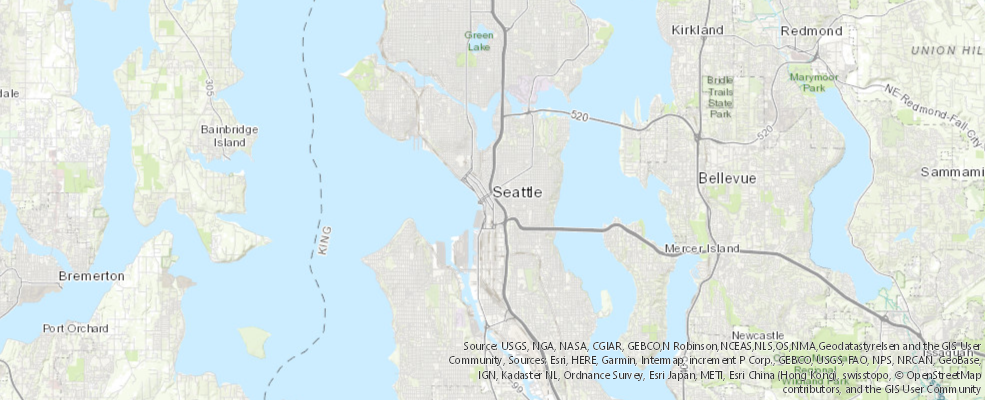

In [21]:
bike_street_filtered_map = gis.map('Seattle')
bike_street_filtered_map

In [22]:
bike_street_filtered_map.add_layer({"type":"FeatureLayer", 
               "url":bike_route_streets.url,
               "definition_expression" : "SEGMENT_TY = 8",
               
              })

There are not enough trails in the Capitol Hill neighborhood so bike lanes will have to be created on pre-existing streets. Since Seattle wants to build protected bike lanes, we will look at busier streets first to find the most direct routes

There are not enough trails in the Capitol Hill neighborhood so bike lanes will have to be created on pre-existing streets. Since Seattle wants to build protected bike lanes, we will look at busier streets first to find the most direct routes. 
Use Find Existing Locations tool to select the arterial streets.

In [24]:
from arcgis.features.find_locations import find_existing_locations

In [25]:
bike_route_streets.url

'https://services6.arcgis.com/sdbe23RSJ4l0hdpd/arcgis/rest/services/SeattleBikeRoutes/FeatureServer/0'

In [30]:
busy_streets = find_existing_locations(input_layers=[{'url': bike_route_streets.url}], 
                        expressions=[{"operator":"","layer":0,"where":"SEGMENT_TY = 1"},
                                     {"operator":"and","layer":0,"where":"ARTERIAL_C = 1"}],
                                       output_name='Arterial_Streets')

In [31]:
from arcgis.features import FeatureLayerCollection

In [32]:
busy_streets.layers[0].query(return_geometry=False, where='1=1')

<FeatureSet> 6605 features

In [33]:
busy_streets

<Item title:"Arterial_Streets" type:Feature Layer Collection owner:demos_deldev>

MapView(layout=Layout(height='400px', width='100%'))


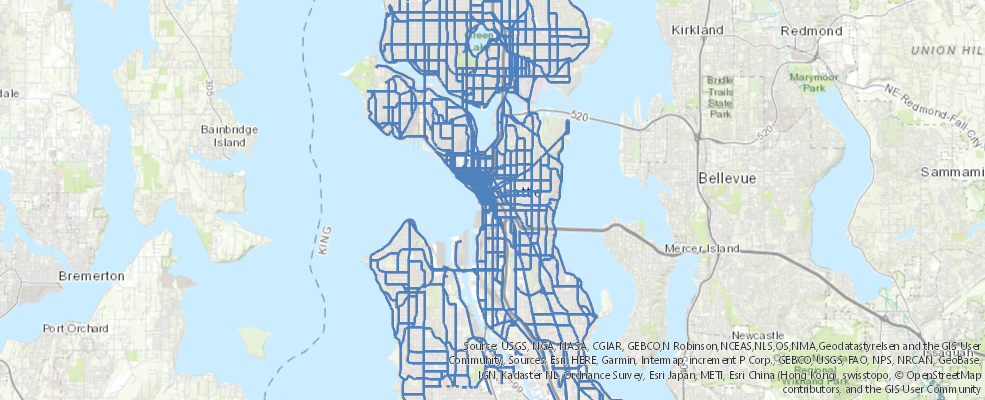

In [34]:
busy_streets_map = gis.map('Seattle')
busy_streets_map

In [35]:
busy_streets_map.add_layer(busy_streets)

Examine the arterial roads in and around the Capitol Hill neighborhood. One road runs through the entire south-eastern side of the neighborhood and into the Downtown Office Core. 

In [37]:
busy_streets.share(everyone=True)

{'itemId': 'ee298f6a0ce84fa6ab5f75d25d2c72b0', 'notSharedWith': []}

In [38]:
busy_streets_layer = busy_streets.layers[0]

In [39]:
busy_streets_layer.url

'https://services6.arcgis.com/SMX5BErCXLM7eDtY/arcgis/rest/services/Arterial_Streets/FeatureServer/0'

Use Find Existing Locations to select the segments of Madison Street that are within 3.5 feet of Capitol Hill. The distance has to be used because the street shares a border with Capitol Hill and some segments are located just outside of the boundary. Note that the actual bike lane would run all the way to the Downtown Office Core , but this analysis is determining how well the lanes service a specific neighborhood, so only the sections of the road within that neighborhood are required. The Neighborhoods filter will be applied to the tool.

In [40]:
bike_route_neighbourhood.url

'https://services6.arcgis.com/sdbe23RSJ4l0hdpd/arcgis/rest/services/SeattleBikeRoutes/FeatureServer/1'

In [41]:
busy_streets_layer.url

'https://services6.arcgis.com/SMX5BErCXLM7eDtY/arcgis/rest/services/Arterial_Streets/FeatureServer/0'

In [43]:
madison_street = find_existing_locations(input_layers=[{'url': busy_streets_layer.url}, {'url': bike_route_neighbourhood.url}], 
                        expressions=[{"operator":"","layer":0,"where":"ORD_STREET = 'MADISON'"},
                                     {"operator":"and","layer":0,"selectingLayer":1,"spatialRel":"withinDistance","distance":3.5,"units":"Feet"}],
                                       output_name='Madison street')

In [44]:
fs = madison_street.layers[0].query(where='1=1', returnGeometry=False, spatialRel='esriSpatialRelIntersects',
                               outFields='Length',
                               outStatistics=[{"statisticType":"count","onStatisticField":"Length","outStatisticFieldName":"countField"},{"statisticType":"sum","onStatisticField":"Length","outStatisticFieldName":"sumField"},{"statisticType":"min","onStatisticField":"Length","outStatisticFieldName":"minField"},{"statisticType":"max","onStatisticField":"Length","outStatisticFieldName":"maxField"},{"statisticType":"avg","onStatisticField":"Length","outStatisticFieldName":"avgField"},{"statisticType":"stddev","onStatisticField":"Length","outStatisticFieldName":"stddevField"}])

In [45]:
fs.df

avgField  countField  maxField  minField  stddevField  sumField  \
0  0.055579          66  0.176863  0.008181     0.028324   3.66824   

                                               SHAPE  
0  {'spatialReference': {'wkid': 2926, 'latestWki...

In [46]:
bike_route_neighbourhood.filter

"L_HOOD = 'CAPITOL HILL'"

In [47]:
madison_street_layer = madison_street.layers[0]

MapView(layout=Layout(height='400px', width='100%'))


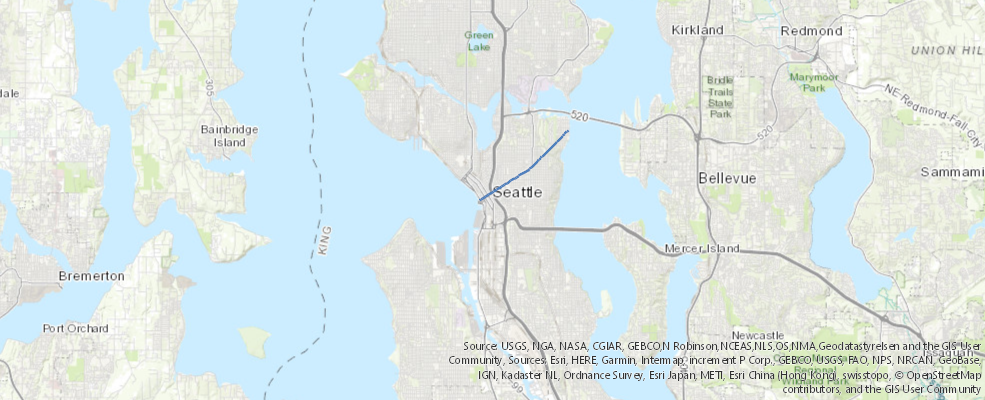

In [48]:
madison_map = gis.map('Seattle')
madison_map

In [49]:
madison_map.add_layer(madison_street)


Apply a Buffer of 0.5 miles to MadisonStreet to determine the area that the bike route would service.

In [51]:
from arcgis.features.use_proximity import create_buffers

In [52]:
buffer_street = create_buffers(madison_street_layer, dissolve_type='Dissolve', distances=[0.5],
               ring_type='Rings', units='Miles', output_name="buffer of madison street")

In [53]:
buffer_street_layer = buffer_street.layers[0]

In [54]:
buffer_street_map = gis.map('Seattle')
buffer_street_map

MapView(layout=Layout(height='400px', width='100%'))

In [55]:
buffer_street_map.add_layer(buffer_street)

Repeat the process (selecting, buffering, and calculating the length of the segments) for 10th Ave E/Broadway E.

In [58]:
broadway_ave = find_existing_locations(input_layers=[{'url': busy_streets_layer.url}, {'url': bike_route_neighbourhood.url}], 
                        expressions=[{"operator":"","layer":0,"where":"ORD_STNAME = '10TH AVE E'"},
                                     {"operator":"or","layer":0,"where":"OBJECTID = 789"},
                                     {"operator":"or","layer":0,"where":"ORD_STNAME = 'BROADWAY'"},
                                     {"operator":"or","layer":0,"where":"ORD_STNAME = 'BROADWAY E'"},
                                     {"operator":"and","layer":0,"selectingLayer":1,"spatialRel":"withinDistance","distance":0.001,"units":"Feet"}],
                                       output_name='Broadway 10th AVE')

In [59]:
broadway_ave_layer = broadway_ave.layers[0]

MapView(layout=Layout(height='400px', width='100%'))


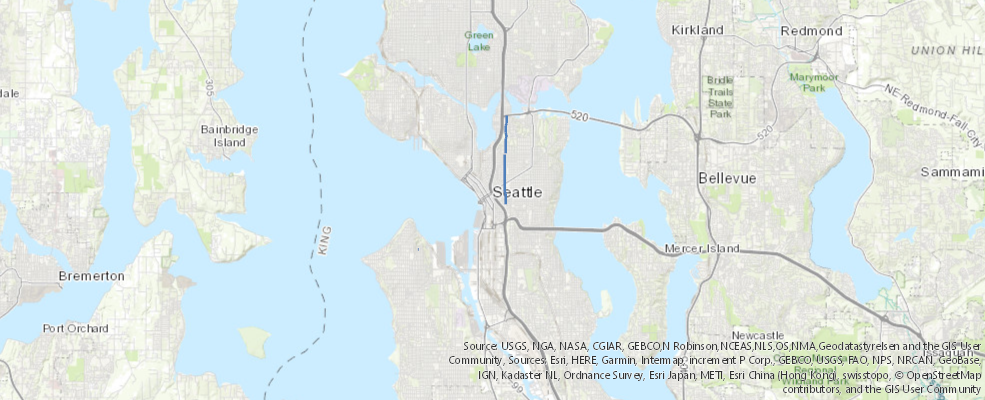

In [60]:
broadway_ave_map = gis.map('Seattle')
broadway_ave_map

In [61]:
broadway_ave_map.add_layer(broadway_ave)

In [66]:
buffer_street_broadway = create_buffers(broadway_ave_layer, dissolve_type='Dissolve', distances=[0.5],
               ring_type='Rings', units='Miles', output_name="buffer of broadway street")

MapView(layout=Layout(height='400px', width='100%'))


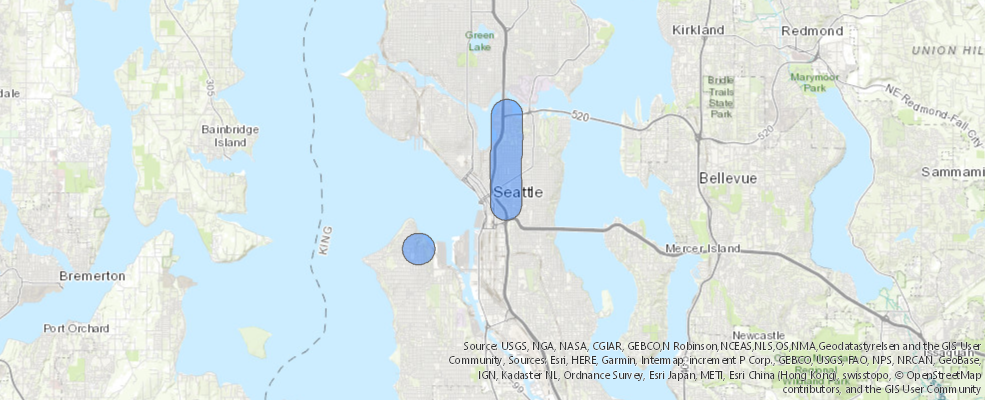

In [67]:
buffer_street_broadway_map = gis.map('Seattle')
buffer_street_broadway_map

In [68]:
buffer_street_broadway_map.add_layer(buffer_street_broadway)

Repeat the process once more for 24th Ave and 23rd Ave.

In [70]:
ave = find_existing_locations(input_layers=[{'url': busy_streets_layer.url}, {'url': bike_route_neighbourhood.url}], 
                        expressions=[{"operator":"","layer":0,"where":"ORD_STNAME = '23RD AVE'"},
                                     {"operator":"or","layer":0,"where":"ORD_STNAME = '23RD AVE E'"},
                                     {"operator":"or","layer":0,"where":"ORD_STNAME = '24TH AVE E'"},
                                     {"operator":"or","layer":0,"where":"ORD_STNAME = 'TURNER WAY E'"},
                                     {"operator":"and","layer":0,"selectingLayer":1,"spatialRel":"withinDistance","distance":0.001,"units":"Feet"}],
                                       output_name='23rd 24th AVE')

In [71]:
ave_layer = ave.layers[0]

MapView(layout=Layout(height='400px', width='100%'))


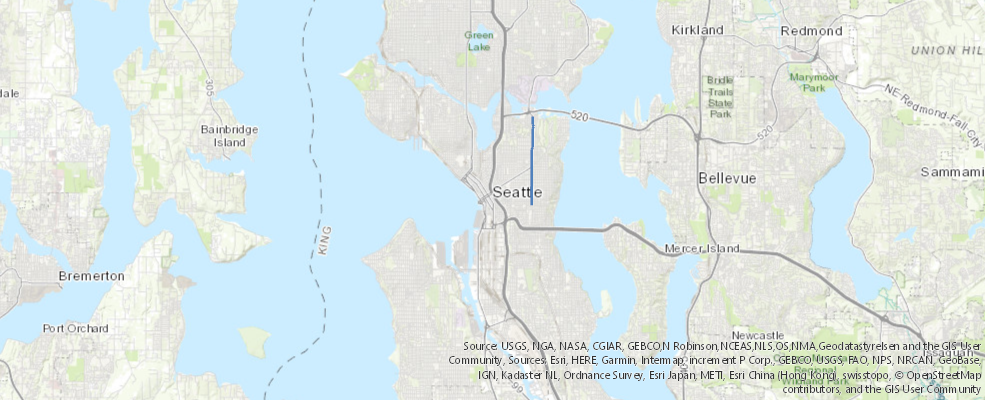

In [74]:
ave_map = gis.map('Seattle')
ave_map

In [75]:
ave_map.add_layer(ave_layer)

In [80]:
buffer_street_ave = create_buffers(ave_layer, dissolve_type='Dissolve', distances=[0.5],
               ring_type='Rings', units='Miles', output_name="Buffer of 23th 24th ave Street")

MapView(layout=Layout(height='400px', width='100%'))


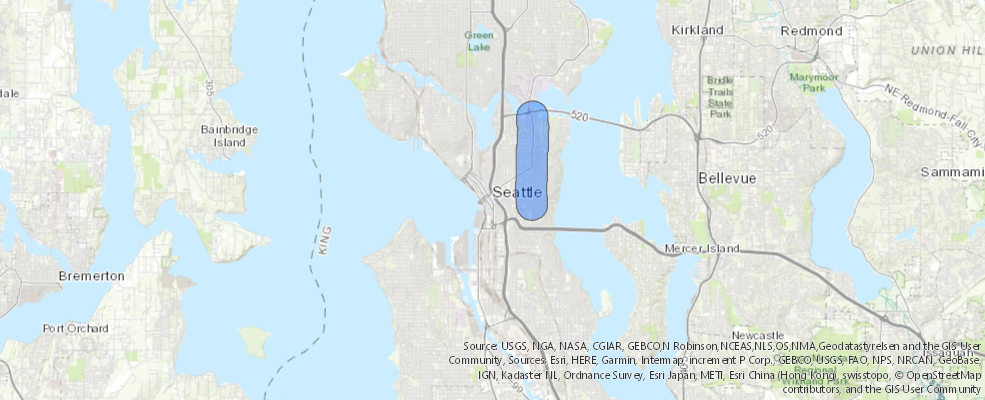

In [81]:
buffer_street_ave_map = gis.map('Seattle')
buffer_street_ave_map

In [82]:
buffer_street_ave_map.add_layer(buffer_street_ave)

In [118]:
all_buffers_map = gis.map('Seattle')
all_buffers_map

MapView(layout=Layout(height='400px', width='100%'))

In [117]:
all_buffers_map.add_layer(buffer_street)
all_buffers_map.add_layer(buffer_street_broadway)
all_buffers_map.add_layer(buffer_street_ave)


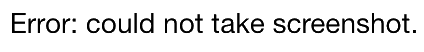

In [114]:
all_buffers_map.take_screenshot()

## Determine the effectiveness of the selected routes

The length of potential bike lanes within the neighborhood will be compared to the length of all of the streets within the neighborhood. Select the streets (SEGMENT_TY=1) within Capitol Hill using Find Existing Locations. 

In [89]:
capitol_hill_streets = find_existing_locations(input_layers=[{'url': bike_route_streets.url}, {'url': bike_route_neighbourhood.url}], 
                        expressions=[{"operator":"","layer":0,"where":"SEGMENT_TY = 1"},
                                     {"operator":"and","layer":0,"selectingLayer":1,"spatialRel":"withinDistance","distance":3.5,"units":"Feet"}],
                                       output_name='Capitol Hill street')

## Applying population data

Use Merge Layers tool to combine the three buffers into a single layer. You will have to run the tool twice to merge all three buffers.

In [90]:
from arcgis.features.manage_data import merge_layers

In [91]:
merge_of_madison_broadway_buffer = merge_layers(buffer_street, buffer_street_broadway, output_name='merge_1')

In [93]:
merge_all_buffers = merge_layers(merge_of_madison_broadway_buffer, buffer_street_2324ave, output_name='merge_2')

MapView(layout=Layout(height='400px', width='100%'))


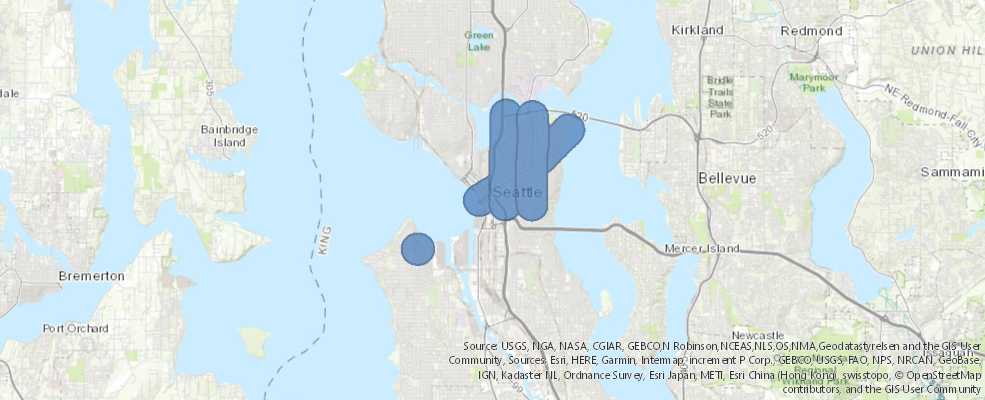

In [94]:
buffer_map = gis.map('Seattle')
buffer_map

In [95]:
buffer_map.add_layer(merge_all_buffers)

Use Dissolve Boundaries tool on the merged buffers so that all of the buffers are in a single polygon.

In [97]:
from arcgis.features.manage_data import dissolve_boundaries

In [98]:
dissolve = dissolve_boundaries(merge_all_buffers, output_name='dissolved Layer')

MapView(layout=Layout(height='400px', width='100%'))


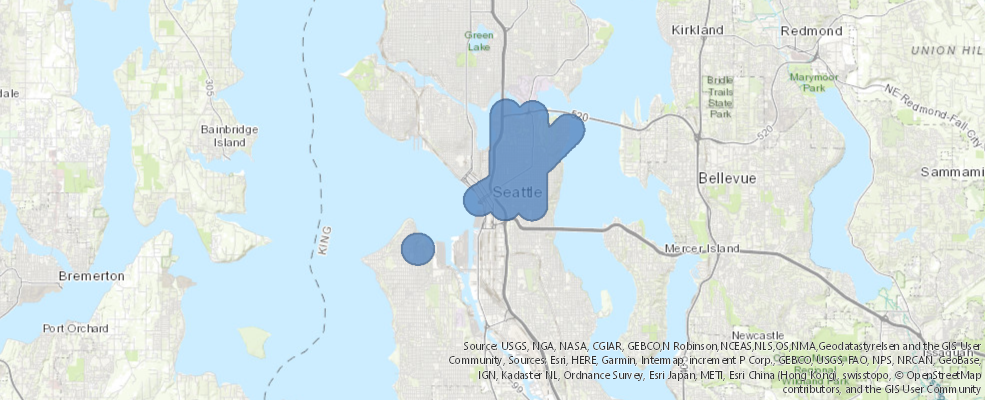

In [99]:
dissolve_map = gis.map('Seattle')
dissolve_map

In [100]:
dissolve_map.add_layer(dissolve)

Use Overlay Layers tool to clip the dissolved buffers to the shape of Capitol Hill. The clipped buffers will be used to determine the number of Capitol Hill residents that live within 1/2 mile of the bike routes.

In [102]:
from arcgis.features.manage_data import overlay_layers

In [103]:
cliped_buffer = overlay_layers(dissolve, bike_route_neighbourhood, tolerance=0, context={},
                           output_name="Cliped Buffer")

In [104]:
cliped_buffer_layer = cliped_buffer.layers[0]

MapView(layout=Layout(height='400px', width='100%'))


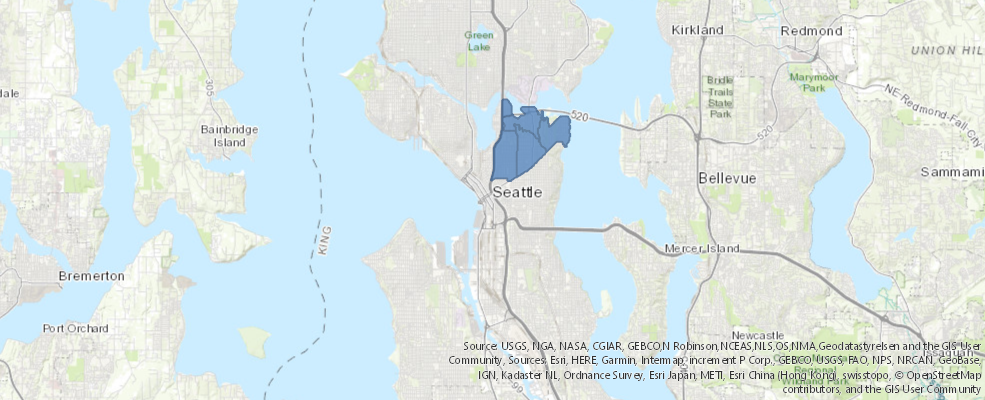

In [105]:
cliped_buffer_map = gis.map('Seattle')
cliped_buffer_map

In [106]:
cliped_buffer_map.add_layer(cliped_buffer)

Use Enrich Layer tool to add population data to the clipped layer made in the previous step.  

In [108]:
from arcgis.features.enrich_data import enrich_layer

In [109]:
clipped_enrich = enrich_layer(cliped_buffer_layer, 
                              analysis_variables=["AtRisk.TOTPOP_CY"], 
                              output_name='enriched with pop')

Use Enrich Layer to add population data to Capitol Hill. Use the same population variable as in the previous step.

In [110]:
capitolhill_enrich = enrich_layer(bike_route_neighbourhood, 
                              analysis_variables=["AtRisk.TOTPOP_CY"], 
                              output_name='capitolhill enriched with pop')

In [111]:
gt = clipped_enrich.layers[0].query(where='1=1', returnGeometry=False, spatialRel='esriSpatialRelIntersects',
                               outFields='TOTPOP_CY',
                               outStatistics=[{"statisticType":"count","onStatisticField":"TOTPOP_CY","outStatisticFieldName":"countField"},{"statisticType":"sum","onStatisticField":"TOTPOP_CY","outStatisticFieldName":"sumField"},{"statisticType":"min","onStatisticField":"TOTPOP_CY","outStatisticFieldName":"minField"},{"statisticType":"max","onStatisticField":"TOTPOP_CY","outStatisticFieldName":"maxField"},{"statisticType":"avg","onStatisticField":"TOTPOP_CY","outStatisticFieldName":"avgField"},{"statisticType":"stddev","onStatisticField":"TOTPOP_CY","outStatisticFieldName":"stddevField"}])

In [112]:
gt.df

avgField  countField  maxField  minField   stddevField  sumField  \
0    9886.2           5     27189      1263  10397.063081     49431   

                                               SHAPE  
0  {'spatialReference': {'wkid': 2926, 'latestWki...